## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [32]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [33]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, SignalKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



## Inputs

In [34]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")

#injected gaussian signals 
sigToys = np.load("newoutputs/signalToys.npy")
sigToysO = np.load("newoutputs/signalToysO.npy")
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]


### Calculate z values and chi squared 

In [35]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


### poisson likelihood

In [36]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits. Add back in zero bins for final prediction

In [37]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

## signal+background and background only plotted together

In [38]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 3e5):
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    #f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="Toy data with injected signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="Gaussian Process background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Gaussian Process signal-plus-background")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=25)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=25)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("background-only fit residuals",(2020,-3.5), fontsize=25)

    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=25)
    ax3.tick_params(axis='x', labelsize=25)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("signal+background fit residuals",(2020,-3.5), fontsize=25)
    
    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)

    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    


### signal only component of signal+background fit

In [39]:
def makePrettyPlots_signalOnly(xs, dM_GP, GPs, data, sig, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
   # f.suptitle(title, fontsize=35, y=1.01)
    dataMinusGPbPlot = ax1.errorbar(xs, dM_GP, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Toy data - Gaussian Process background")
    dataPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")
    sigPlot = ax1.plot(xs, sig, linewidth=3.0, c='red',label="Injected signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
   # ax1.set_ylim([-3.5*max(GPs), 3.5*max(GPs)])
    ax1.set_ylim([-50, 75])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

    plt.show()

In [101]:
def makePrettyPlots_signalOnly2(xs, data, GPs, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, data, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Injected Signal")
    sigPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    #ax1.set_ylim([-3, 1.5*max(GPs)])
    ax1.set_ylim([-0.1, 40])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Mean function for GP

In [41]:
def model_gp(params, t, xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### piecewise linear function for signal

In [42]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

### right triangle function for signal

In [43]:
def triangle(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    offset=10.
    slope1 = amp/(2.*width-offset)
    y1 = amp*(-center+width)/(2*width-offset)
    slope2 = -amp/offset
    y2 = amp*(center+width)/offset
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width-offset: 
            output[i]=slope1*c+y1
        if c > center+width-offset and c < center+width:
            output[i]=slope2*c+y2
    output = [s if s > 0 else 0 for s in output]
    return output

### square signal function

In [44]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

### Gaussian signal function

In [45]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

### Smearing functions - use Gaussian kernel to smooth out signals

In [46]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [47]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

## OLD KERNEL

### Fit signal GP hyperparameters by minimizing george likelihood with minuit. Keep hyperparameters for background GP fixed

In [48]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian signals

parameters (300, 3500, 250)
(266.522127860292, 3006.4597272780106, 110.36870963552855)
(539.7134216935775, 3591.9431188096523, 212.29088446811434)
(539.1120306851494, 3591.9343686742986, 212.29019116155513)
(538.7143924411761, 3591.93894748335, 212.2428149415691)
(538.7971550347582, 3591.944503565876, 212.25586862339605)
(539.1179201442386, 3591.953698257431, 212.2633776770702)
A, mass, tau 539.117920144 3591.95369826 212.263377677


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.1423355331


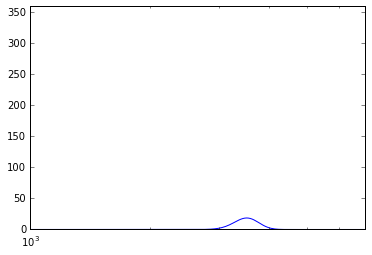

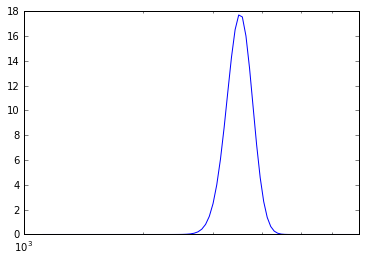

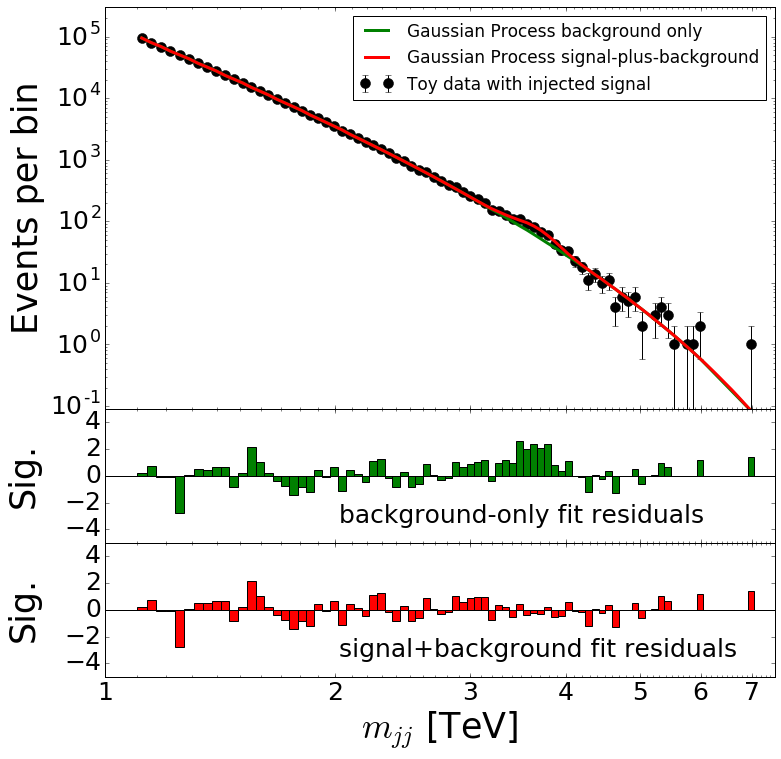

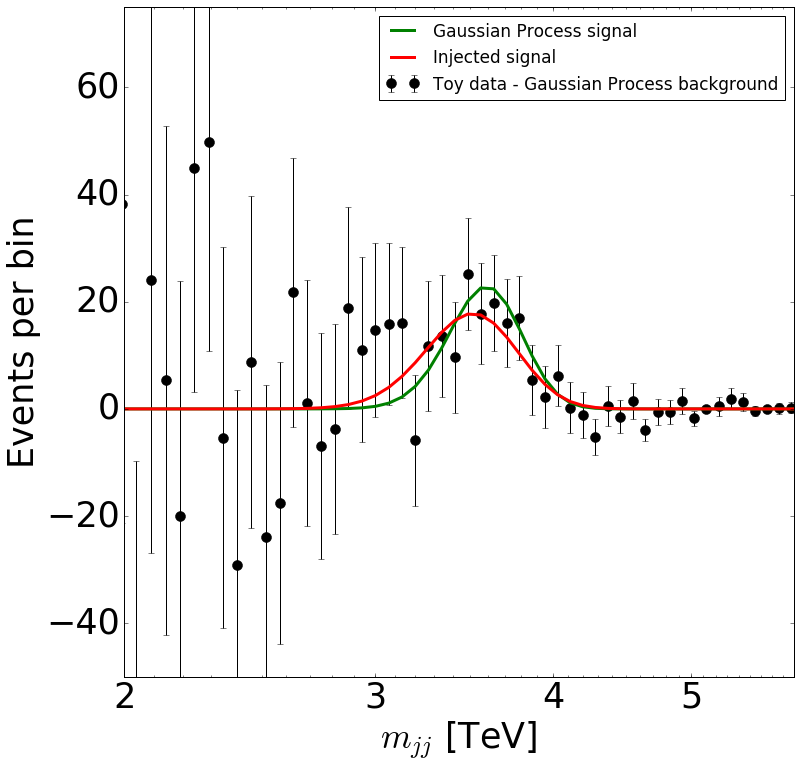

In [49]:
aa={}
mm={}
ww={}
#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        
        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)        
        

        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

### Peak signals

parameters (60, 3500, 250)
(81.09807113819453, 2976.6840183715376, 100.01465433644512)
(3235.1651918812977, 1779.3313545004457, 100.00000838987965)
(842.218779301025, 3532.8230460792556, 102.15707570547042)
(839.9758400698717, 3532.7553198206824, 102.17269022987026)
(840.1321906275283, 3532.796628972426, 102.22372035503481)
A, mass, tau 840.132190628 3532.79662897 102.223720355


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.4533496237


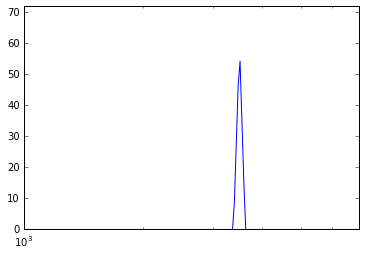

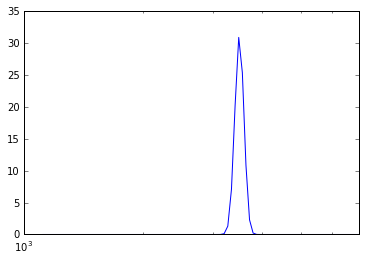

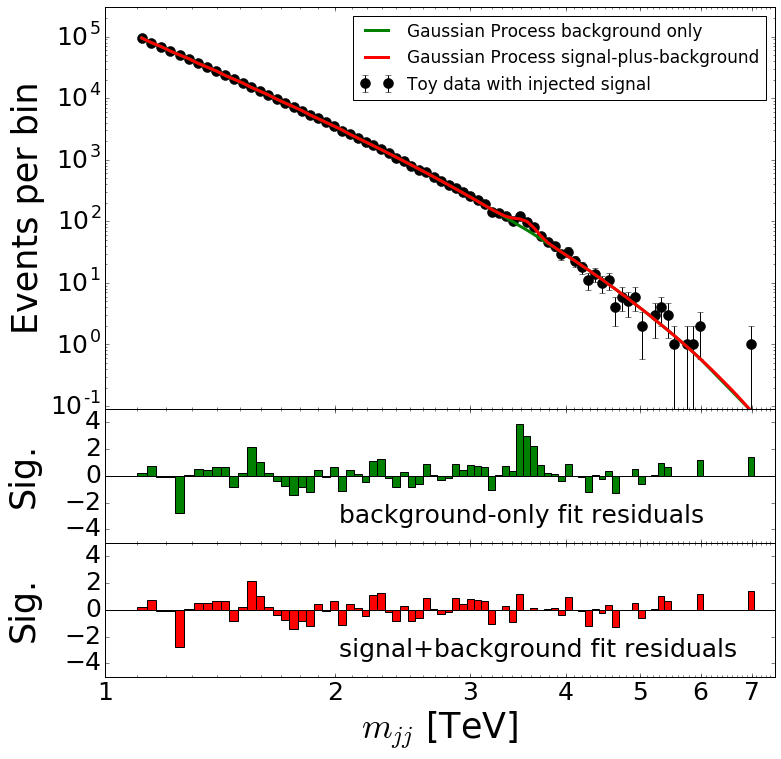

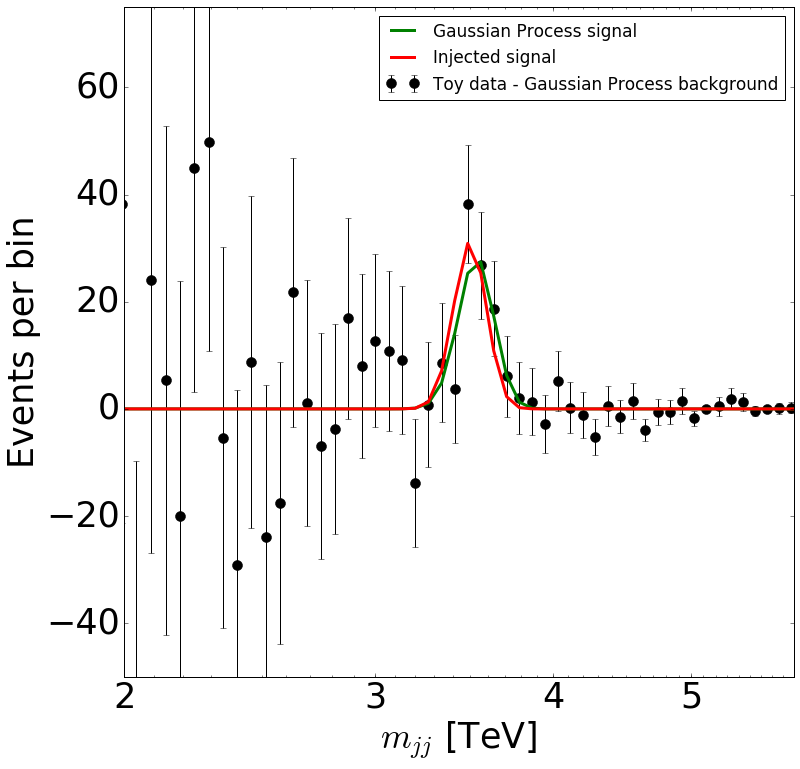

In [50]:
aa={}
mm={}
ww={}
#standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
#                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### square signals

parameters (20, 3500, 250)
(3215.8769560738465, 1779.5014587090222, 100.00000009881084)
(2604.813003018559, 3635.54251996321, 134.7255015348941)
(501.40426356857375, 3496.2256762744205, 190.74533388332904)
A, mass, tau 501.404263569 3496.22567627 190.745333883


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 63.6244848946


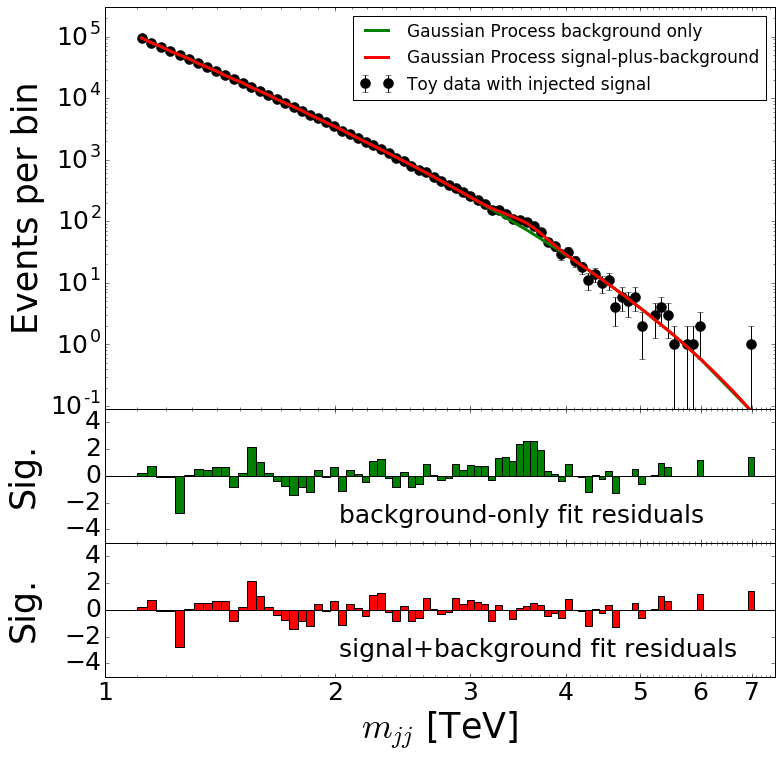

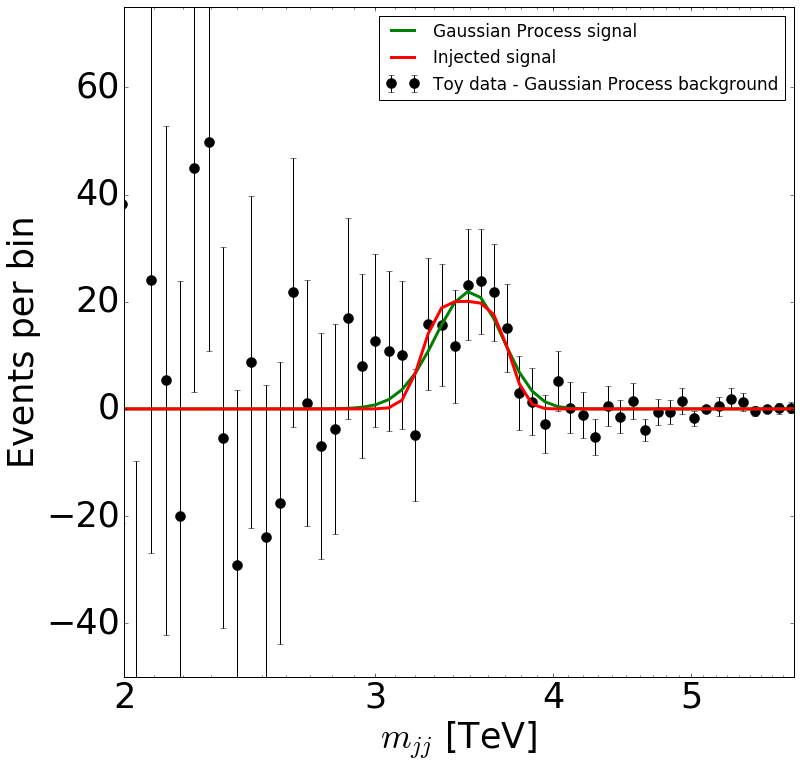

In [51]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### Right Triangle

parameters (40, 3520, 250)
(1431.8441022908103, 3645.866833106736, 117.96959461418896)
(1446.0456690864164, 3645.8685449442605, 118.0924730752871)
(1445.5992840312906, 3645.830063281986, 118.08200036846105)
A, mass, tau 1445.59928403 3645.83006328 118.082000368


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.6153979939


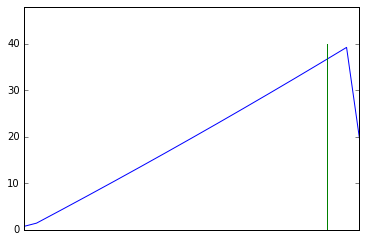

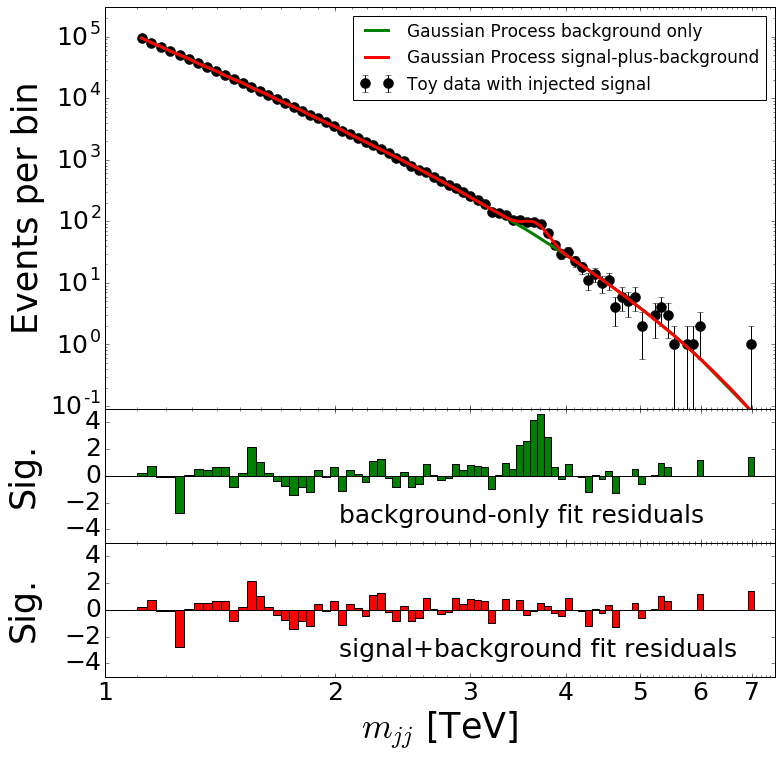

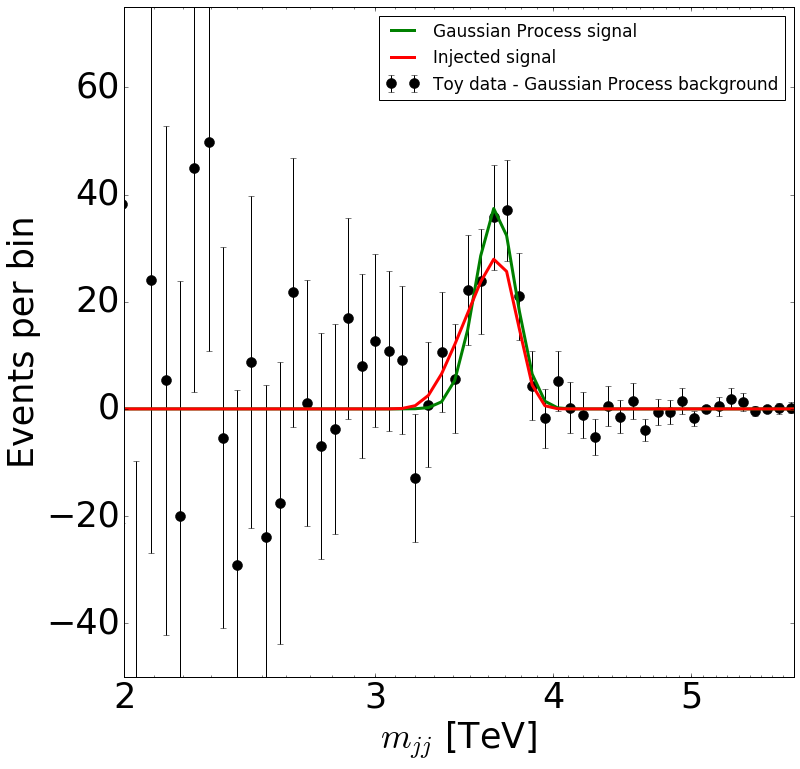

In [52]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## NEW SIGNAL KERNEL

In [53]:
class logLike_gp_fitgpsigNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams 
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsigNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L =1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (10, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(2.4880272427720795, 1000.000000043289, 100.00000000022828, 39.49667922383572)
(309.2202420497984, 3668.2545418415484, 430.5472648045779, 713.1189814156913)
(441.87853898460264, 3539.2684033649557, 258.80727115226426, 9999.639924308303)
(442.21193971856, 3539.268097491257, 258.77656632538327, 9999.998443473249)
A, mass, tau, L 442.211939719 3539.26809749 258.776566325 9999.99844347


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.9647715017


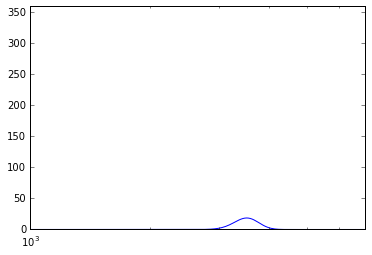

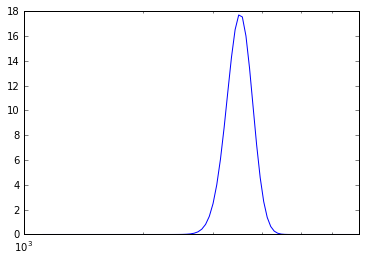

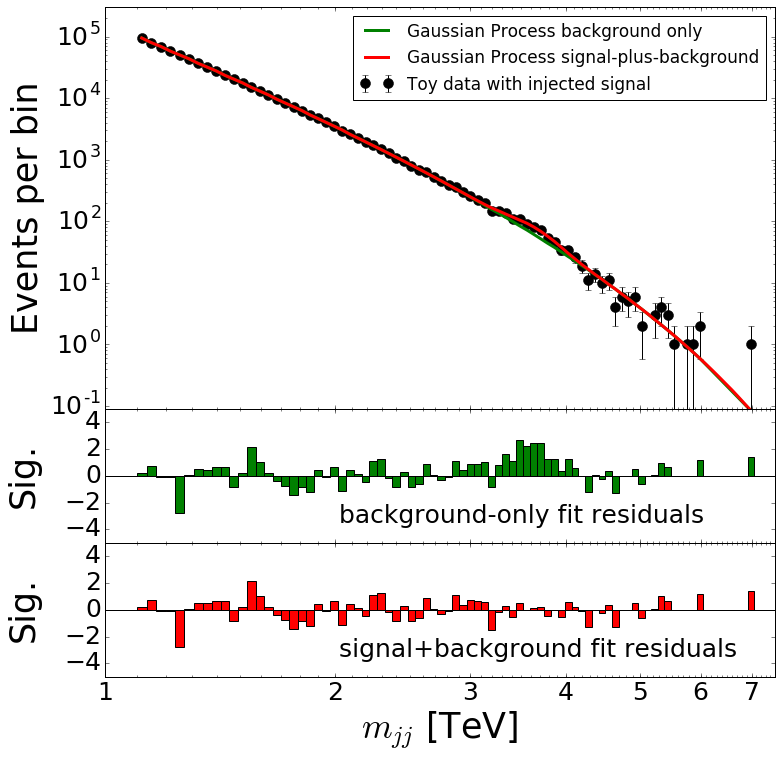

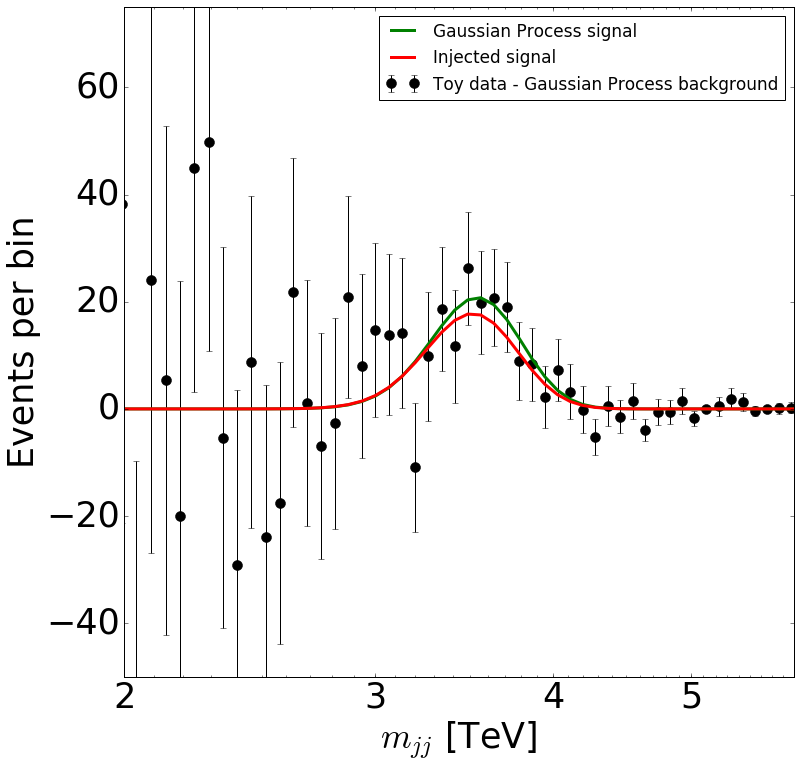

In [54]:
standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

### Peak Signal

parameters (60, 3500, 250)
(3778.8835901655784, 1758.6976197600322, 100.00053932117991, 113.11339655861475)
(11344.120158826116, 1652.038345091859, 125.45505020148454, 98.03805787791705)
(839.5864427944795, 3528.7446524699208, 123.94331088286661, 9922.154691881322)
(841.5723906471503, 3528.7529008057422, 123.92888948371971, 9991.968452893645)
A, mass, tau, L 841.572390647 3528.75290081 123.928889484 9991.96845289


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 66.4695588132


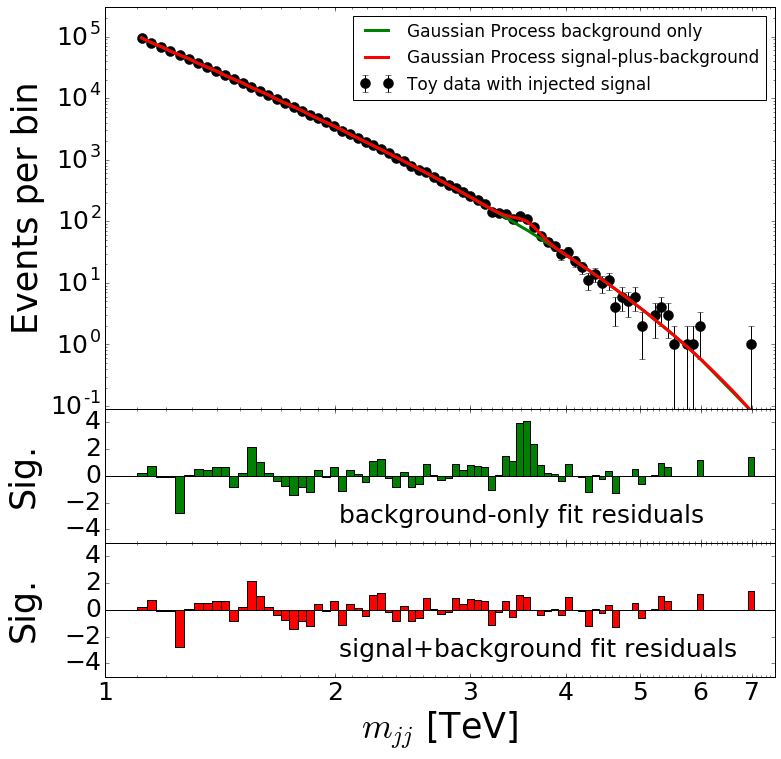

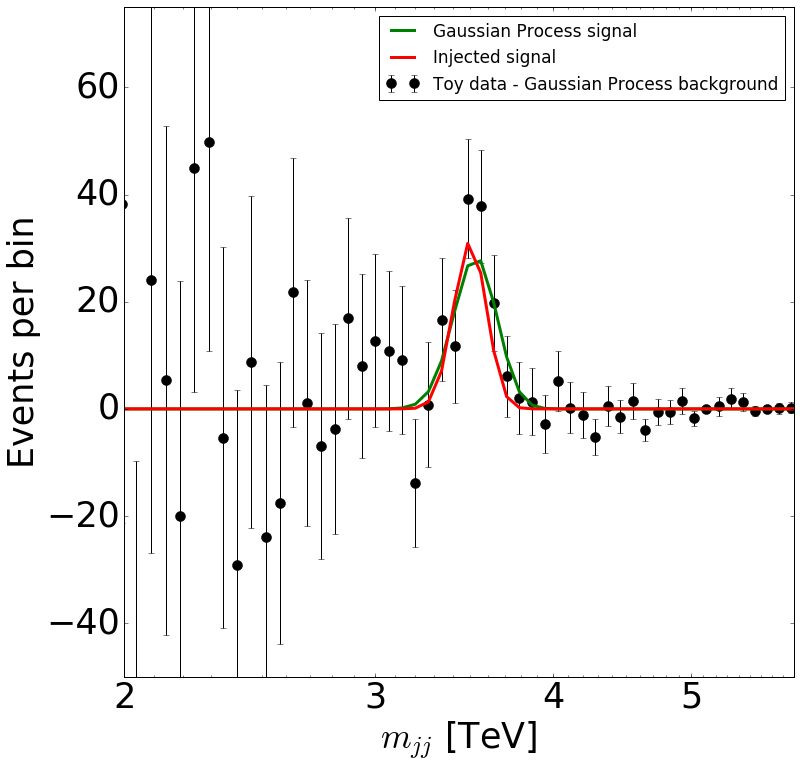

In [55]:
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)

        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)




### Square Signal

parameters (20, 3500, 250)
(556.2193464326742, 3540.4354287585556, 183.8886820966749, 9994.257256061066)
(554.5215941980664, 3540.4175183852176, 183.7587205926328, 9996.724414587574)
(553.7444320873608, 3540.4387605810366, 183.84660667073587, 9999.983897448283)
A, mass, tau, L 553.744432087 3540.43876058 183.846606671 9999.98389745
[  5.46293733e-03   3.32353726e-03   2.00680327e-03   1.20264918e-03
   7.15324396e-04   4.19108956e-04   2.43714158e-04   1.40658018e-04
   7.99664935e-05   4.51212921e-05   2.52688174e-05   1.39395301e-05
   7.63205104e-06   4.14728911e-06   2.21997041e-06   1.17939688e-06
   6.21874395e-07   3.23001996e-07   1.65259930e-07   8.39189107e-08
   4.22943179e-08   2.09973284e-08   1.02684734e-08   4.94660869e-09
   2.36504356e-09   1.12227930e-09   5.24694798e-10   2.53567558e-10
   5.61432886e-10   3.75301734e-09   2.43042960e-08   1.48868232e-07
   8.58185954e-07   4.63302723e-06   2.33055778e-05   1.08677005e-04
   4.67340191e-04   1.84350755e-03   6.634913

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 66.2551444852


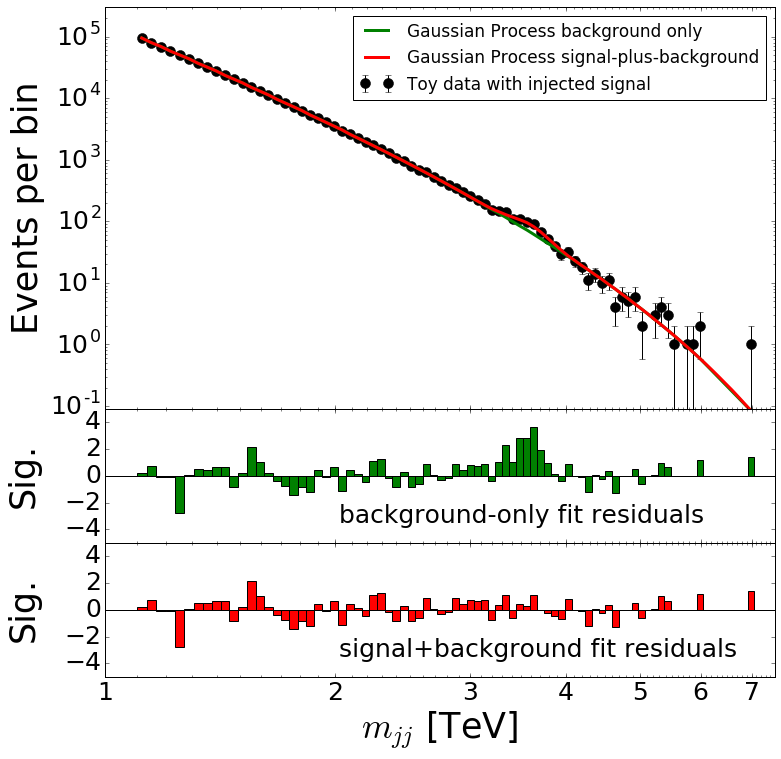

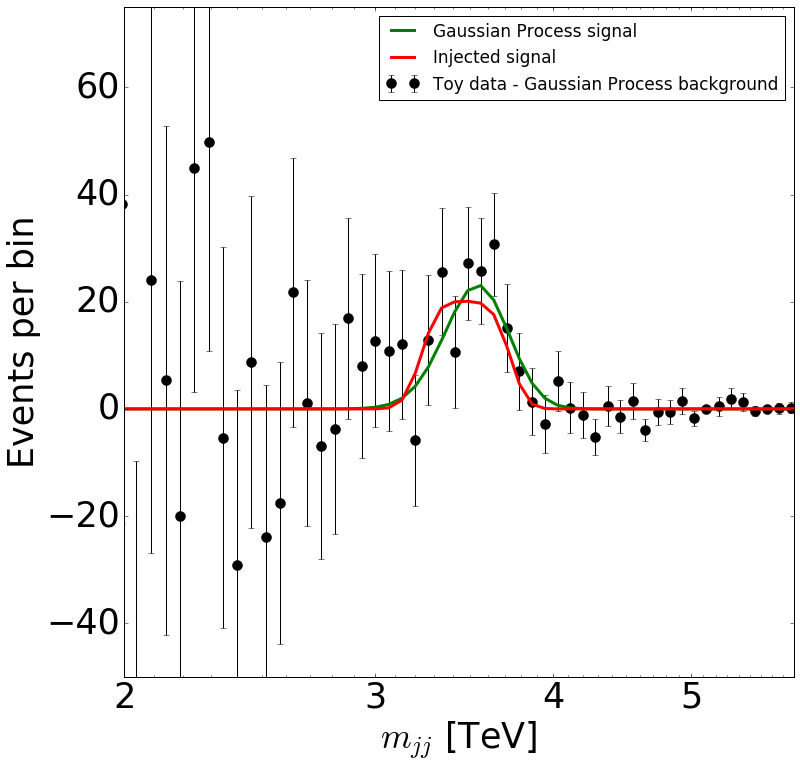

In [56]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)

        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
  
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp, covGP = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        print np.sqrt(np.diag(covGP))
        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)





### Right Triangle

parameters (40, 3520, 250)
(1.9647679403157778, 1000.0000000001669, 100.0, 39.59770088885131)
(1.1622152079946295, 1000.0000176883631, 100.00000130300148, 38.212932142996614)
(3747.183771675703, 1758.9947762648492, 100.00000092064639, 112.8935623853889)
(11263.94351572987, 1652.232738084429, 125.46483705816289, 97.50429662919079)
(11318.564153883077, 1652.180809670426, 125.54736600332208, 97.96747180979982)
(11410.07429081375, 1652.1782758817558, 125.22727840359002, 98.21030737169535)
(11352.854953592447, 1652.1642035007553, 125.45918537882064, 98.20579965275616)
(11353.164968462024, 1652.094644931106, 125.39193592028757, 98.07941538739672)
(1607.8331910827867, 3636.5602221199997, 112.72255595711056, 9991.677386639027)
(1607.1888500272103, 3636.6144708895094, 112.75866201132808, 9997.646780768433)
(1605.0173818868518, 3636.6250094450215, 112.70465405635176, 9997.727613917192)
A, mass, tau 1605.01738189 3636.62500945 112.704654056 9997.72761392


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 67.7187500877


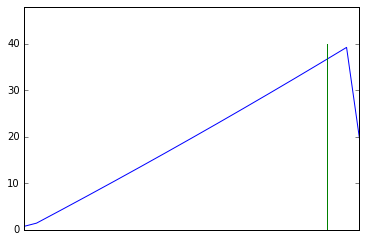

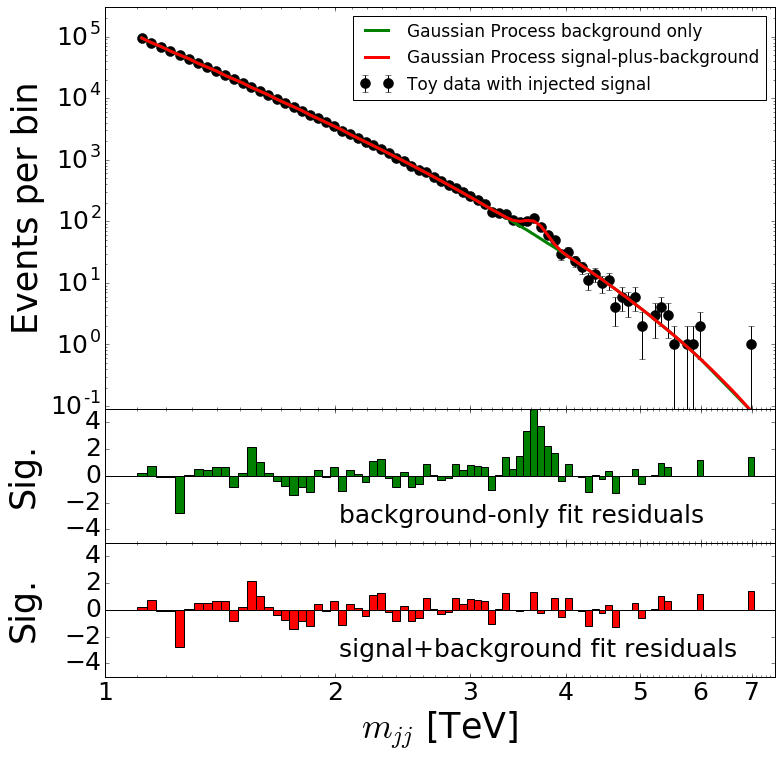

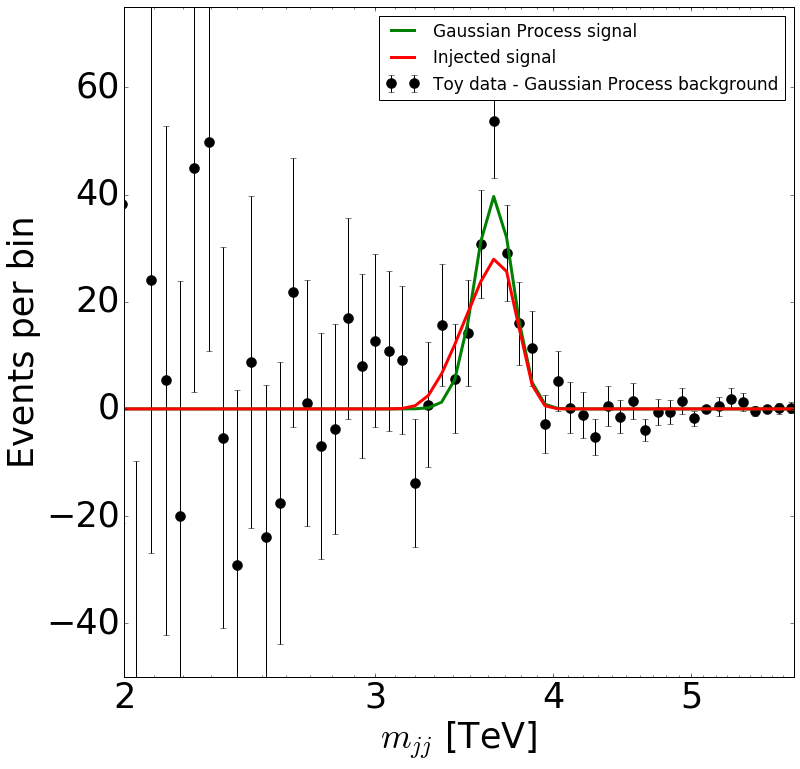

In [57]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



## SIGNAL ONLY FIT

In [102]:
class logLike_gp_fitgpsigonlyNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        kernel = A * SignalKernel(m = mass, t = tau, L = L)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonlyNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (100, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [103]:
class logLike_gp_fitgpsigonly:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonly_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 100), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Gaussian Signal

parameters (300, 3500, 250)
(1.0000304406250282, 6486.957928677298, 100.0000319977134)
(1.0000001241788543, 6486.992612016889, 100.00000000596128)
(99.99971261872804, 3427.9266199271565, 103.89146465989224)
(99.99999998771783, 3427.956418479891, 103.88380047827661)
(99.99999999091223, 3427.9594905095305, 103.88365317929902)
(99.99999993116606, 3427.956692163681, 103.8840991233097)
A, mass, tau 99.9999999312 3427.95669216 103.884099123
[  7.53071923e-108   8.40529809e-105   9.41070308e-102   1.05201303e-098
   1.16868612e-095   1.41792642e-092   1.68753683e-089   1.96030425e-086
   2.42958225e-083   2.89904181e-080   3.31282330e-077   3.94071869e-074
   4.42482060e-071   4.66384833e-068   4.98607269e-065   4.92834976e-062
   4.47752356e-059   4.01521077e-056   3.51124606e-053   2.74934365e-050
   1.91555778e-047   1.26405949e-044   7.79887487e-042   4.43970384e-039
   2.16247897e-036   8.95092249e-034   3.31160168e-031   1.07985646e-028
   3.05938493e-026   7.42171303e-024   1.51885809e

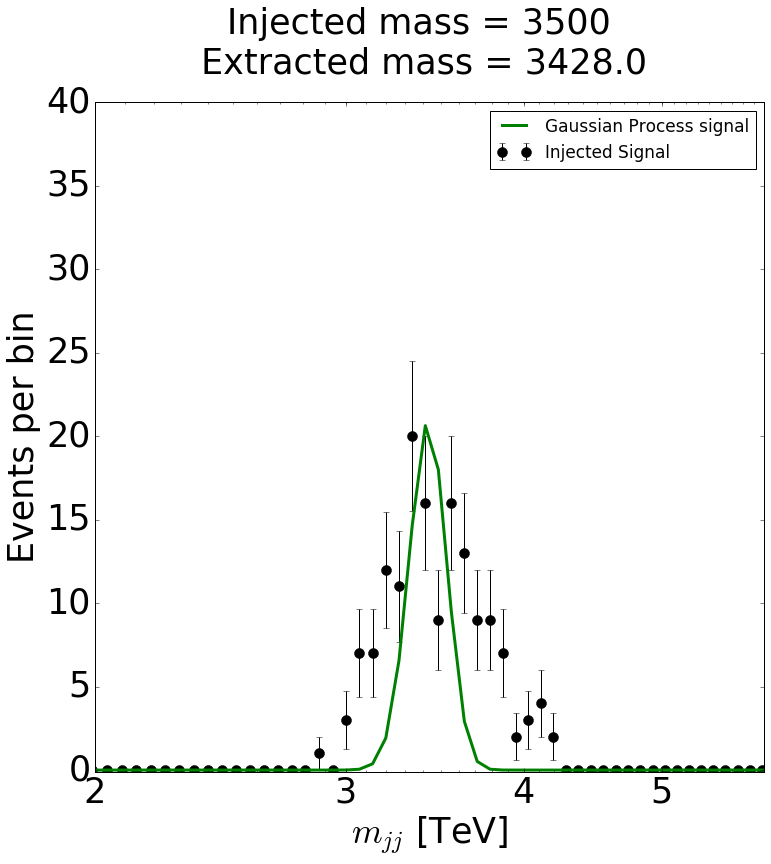

(99.99936443768104, 3428.0895039541733, 103.87359817481736, 9901.066473314704)
(99.99987983118359, 3427.9769076796806, 103.88563564225055, 9988.363829666374)
(99.99999510257139, 3427.9464691518847, 103.8864424495761, 9994.984247641229)
(99.99999745926371, 3427.9474248778024, 103.88679954465647, 9999.561523804005)
(99.99999991208291, 3427.975266427805, 103.88560873681575, 9999.141820477038)
A, mass, tau 99.9999999121 3427.97526643 103.885608737 9999.14182048
[  1.02539899e-107   1.13705950e-104   1.26469284e-101   1.40435566e-098
   1.54955808e-095   1.86696871e-092   2.20634409e-089   2.54474715e-086
   3.13096058e-083   3.70845548e-080   4.20628767e-077   4.96555599e-074
   5.53291248e-071   5.78688060e-068   6.13816353e-065   6.01926316e-062
   5.42534017e-059   4.82606666e-056   4.18596433e-053   3.25095222e-050
   2.24660431e-047   1.47033952e-044   8.99656508e-042   5.07898390e-039
   2.45347004e-036   1.00725027e-033   3.69620041e-031   1.19549720e-028
   3.35977435e-026   8.0856

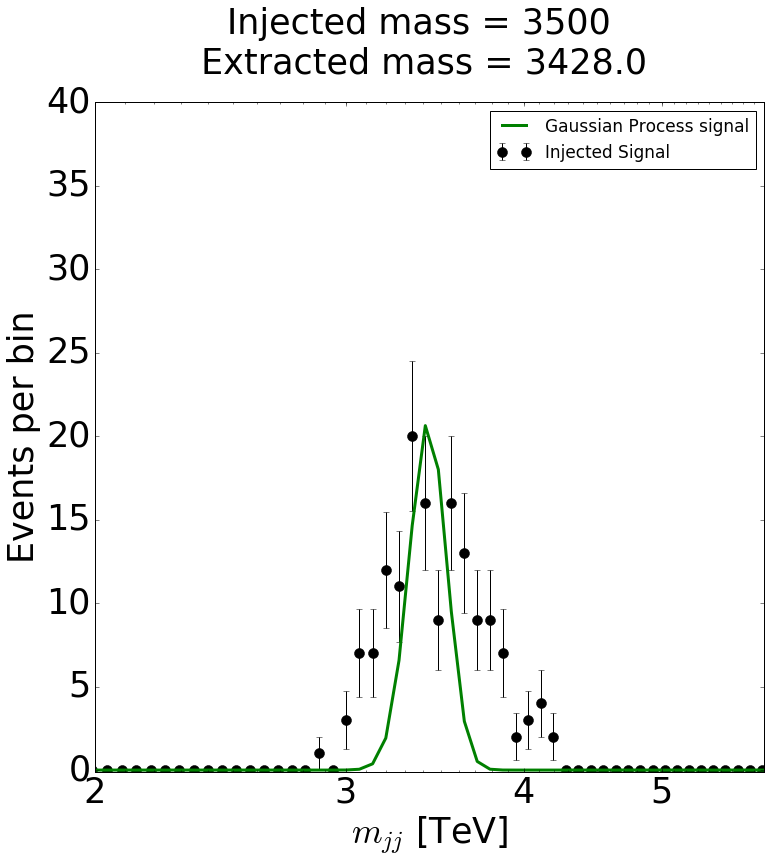

In [104]:

standardParamSets=[(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)
        ####################################################################################

        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
            
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Peak Signal

parameters (60, 3500, 250)
(1.0000015920912428, 6486.993015497432, 100.00000694986804)
(1.0000001189222816, 6486.9997375762, 100.0000004060075)
(1.0000000000009728, 6487.000077922601, 100.00000005833397)
(1.0000000013555677, 6487.000023147908, 100.00000000000348)
A, mass, tau 1.00000000136 6487.00002315 100.0
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e

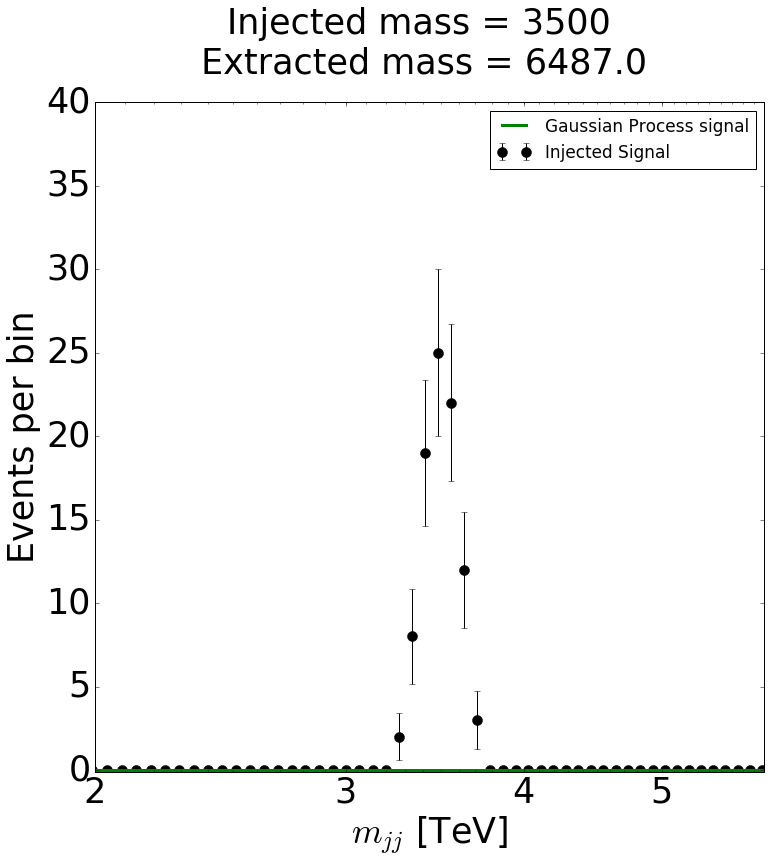

(1.0000031499407458, 1000.0000000040701, 100.0002462790065, 9999.92508802592)
(1.0000026633512376, 1000.0000219761159, 100.00000223869534, 9999.999670308865)
(1.0000044919288105, 3499.917362944863, 100.00001749162793, 9999.99721001168)
(1.0000002664755772, 6486.980204064856, 100.000003183674, 9999.864339008847)
(1.0000005352367318, 6487.012911944962, 100.00000034218472, 9999.986879508602)
(1.0000000000079081, 6486.9999574330095, 100.00000000001516, 9999.988648473214)
(1.000000000000011, 6486.9996436217925, 100.00000000000003, 9999.994751023083)
(1.0000000009426995, 6487.000017800973, 100.00000000016823, 9999.999780581702)
(1.0000000009426995, 6487.000017800973, 100.00000000016823, 9999.999780581702)
A, mass, tau 1.00000000094 6487.0000178 100.0 9999.99978058
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.0000000

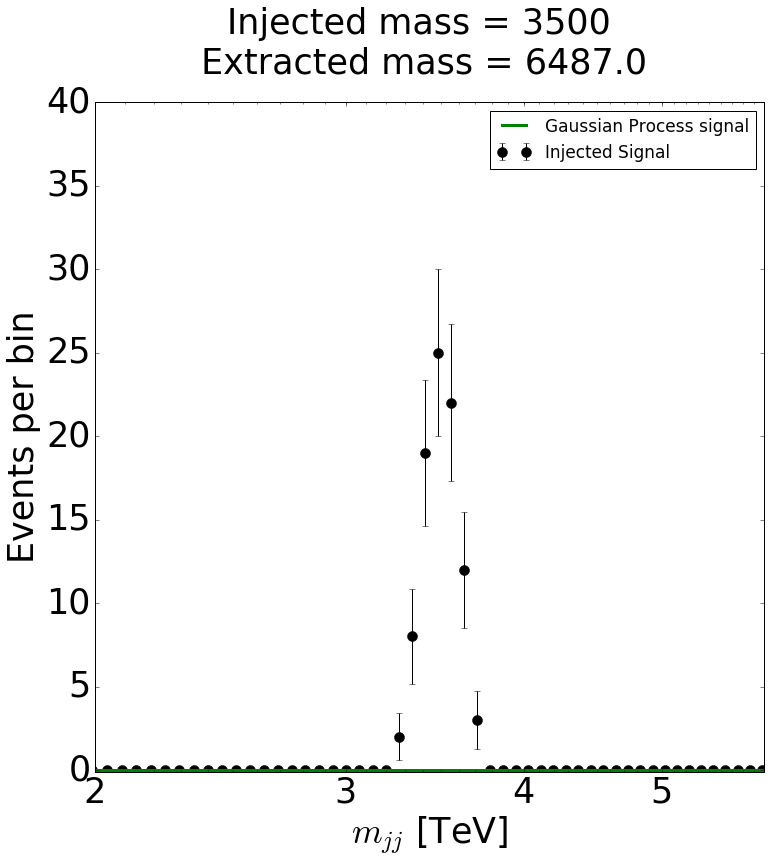

In [107]:
standardParamSets = [(60, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        #plt.figure()
        #plt.plot(xvalO, smeared_countsO)
        #plt.xlim([1000,7000])
        #plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        #########################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

### Square Signal

parameters (20, 3500, 250)
(99.9999079658809, 1000.0057255195965, 100.00006497390793)
(1.0000000415670394, 6999.982927578637, 282.3331233791005)
(1.0000000000145524, 3467.021438605073, 100.00000004843595)
(1.000000009605464, 6487.036788523484, 100.00000043777976)
(1.0000000137670595, 6486.991071930281, 100.0000000065207)
(1.0000000000160691, 6487.00047007602, 100.0000000000002)
(1.000000000135291, 6487.000188954659, 100.0000000000069)
A, mass, tau 1.00000000014 6487.00018895 100.0
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   

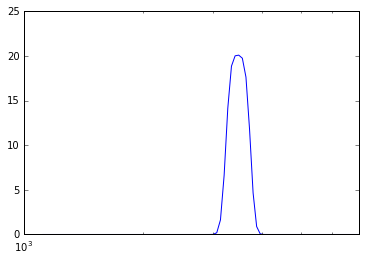

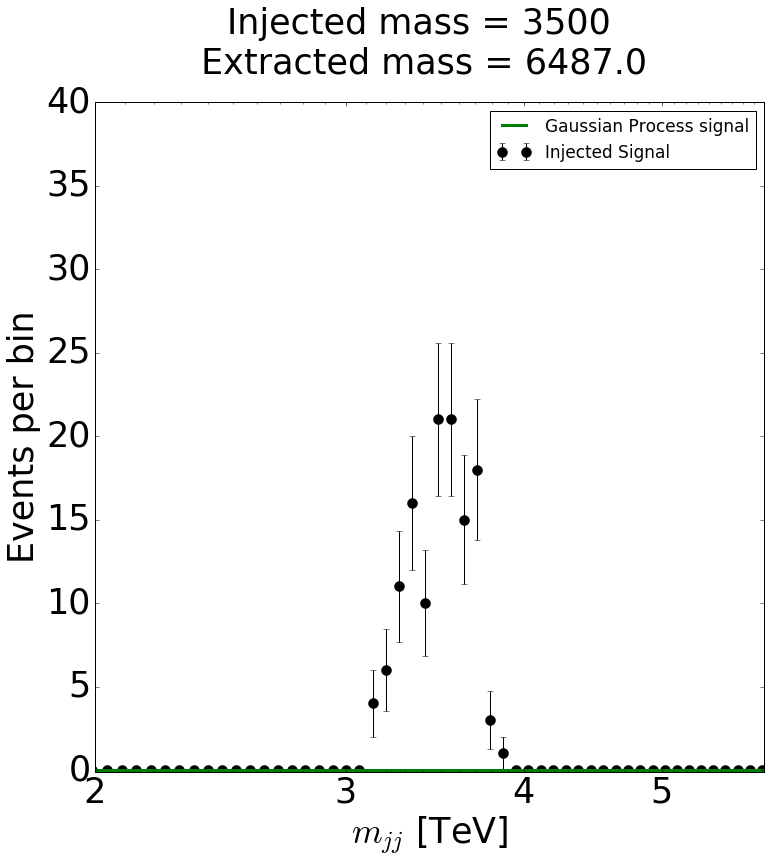

(1.000000006238802, 3518.2719833942333, 100.00000012341872, 9999.999227203201)
(99.99999835899828, 3473.1623273731157, 100.00000112090444, 142.16670237484075)
(99.99999999313566, 3473.2127866680257, 100.00000040457009, 142.1177246113167)
(99.99998610171333, 3473.199138621458, 100.0000000003469, 142.21761977942032)
(99.99999235737059, 3473.183790336792, 100.00000011403327, 142.1547828444593)
(99.9999989907468, 3473.208189479384, 100.00000000143578, 142.1620425587687)
(99.99999996003837, 3473.1892754877877, 100.00000041199269, 142.17840037972877)
(99.99999996003837, 3473.1892754877877, 100.00000041199269, 142.17840037972877)
A, mass, tau 99.99999996 3473.18927549 100.000000412 142.17840038
[  2.49323604e-120   5.63192187e-117   1.27935607e-113   2.90794044e-110
   6.57997033e-107   1.64489118e-103   4.03659000e-100   9.67188563e-097
   2.49653841e-093   6.19950245e-090   1.47262248e-086   3.66947870e-083
   8.61109395e-080   1.89167938e-076   4.23891630e-073   8.74731908e-070
   1.651854

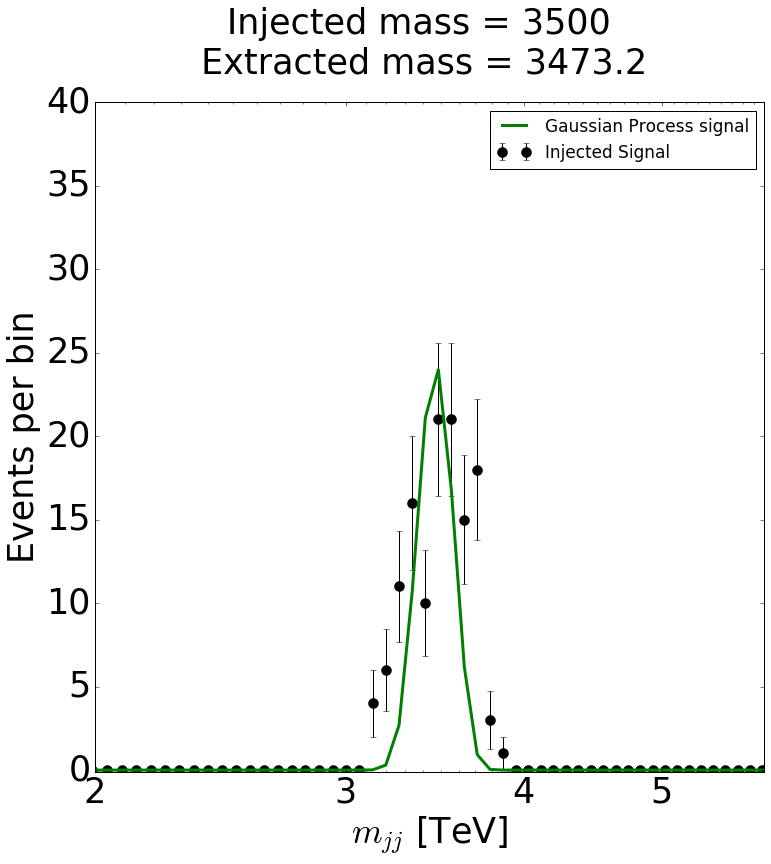

In [108]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)

        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)
        

### Right Triangle

parameters (40, 3520, 250)
(99.99998967703239, 1000.010352817436, 100.00044117408126)
(1.0000001369293807, 6487.007728945698, 100.00000813013534)
(1.0000002051984773, 6487.000055806334, 100.0)
(1.0000000000132279, 6487.001156946984, 100.00000000003133)
(1.0000000004429457, 6487.00022820222, 100.00000000134301)
A, mass, tau 1.00000000044 6487.0002282 100.000000001
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e

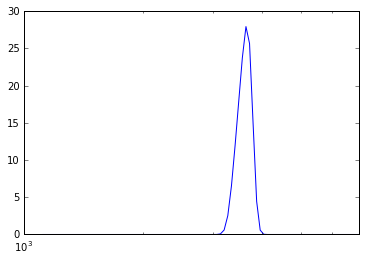

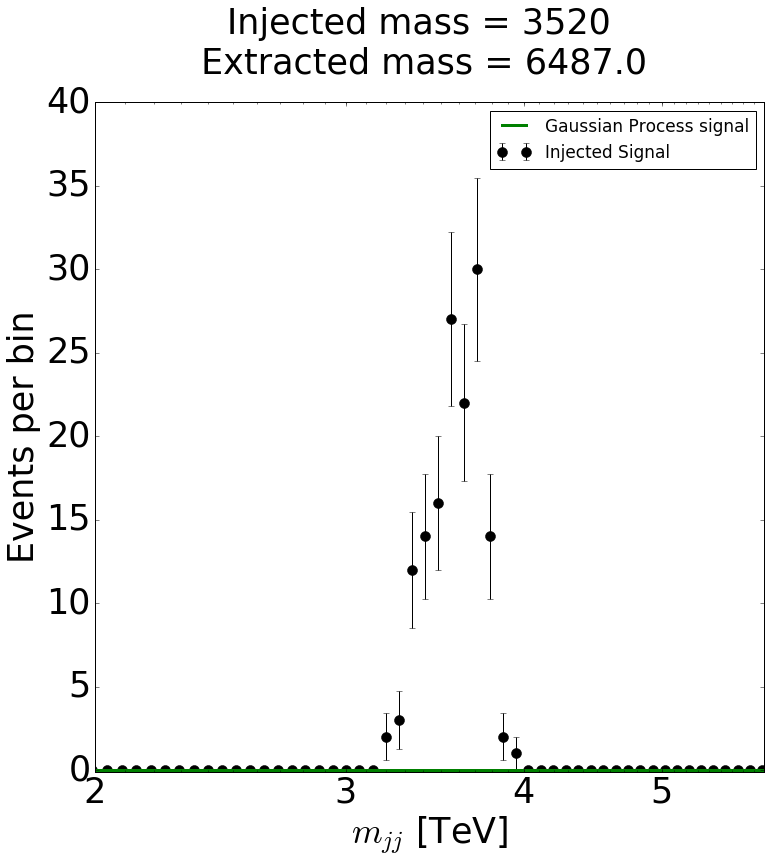

(99.99999016808131, 3613.1762231298208, 100.00000900339776, 150.40625997194337)
(99.99999984010375, 3613.285918520931, 100.0000000015054, 150.59373832978872)
(99.99995680555023, 3613.3232172539974, 100.0000002627466, 150.53818707287184)
(99.99999705185883, 3613.3207225706296, 100.00000000279687, 150.4911223497209)
(99.9999998936769, 3613.3024267126702, 100.00000000007638, 150.45432402337977)
(99.99999996221511, 3613.281566383259, 100.00000009918996, 150.46830546396066)
(99.99999996221511, 3613.281566383259, 100.00000009918996, 150.46830546396066)
A, mass, tau 99.9999999622 3613.28156638 100.000000099 150.468305464
[  4.28732825e-135   1.53764578e-131   5.58482438e-128   2.04392080e-124
   7.49902891e-121   3.08251310e-117   1.25259632e-113   5.00470454e-110
   2.18454237e-106   9.23795942e-103   3.76313415e-099   1.63074418e-095
   6.70200966e-092   2.59657920e-088   1.04063957e-084   3.86771070e-081
   1.32472720e-077   4.55756536e-074   1.55455394e-070   4.75026500e-067
   1.29162827

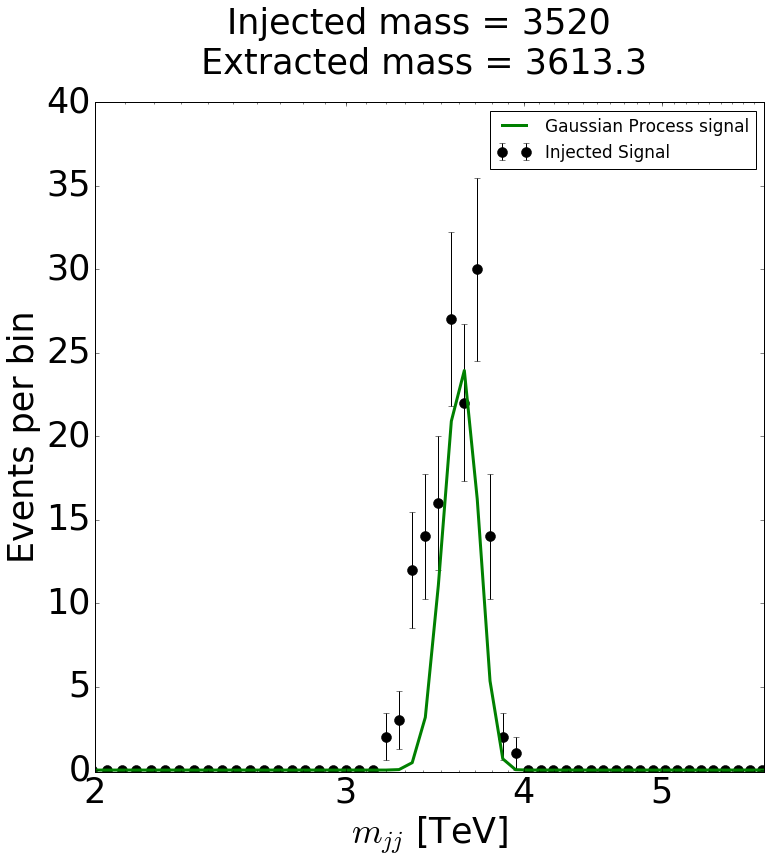

In [109]:
standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        

        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        
        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGP, covGP = gp.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP, m, label)


        ##############################################################################
        
        lnProb2 = logLike_gp_fitgpsigonlyNew(xtoy,ydata, xtoyerr)
        bestval2, best_fit_new2 = fit_gp_fitgpsigonlyNew_minuit(lnProb2, False)
        if np.isinf(bestval2): 
            print "failed"
            continue
        
        print best_fit_new2
        A, mass, tau, L = best_fit_new2 
        print "A, mass, tau", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        
        gp2 = george.GP(kernel2)
        gp2.compute(xtoy, np.sqrt(ydata))
        meanGP2, covGP2 = gp2.predict( ydata, xvalO)
        
        print np.sqrt(np.diag(covGP2))

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))

        makePrettyPlots_signalOnly2(xvalO, ydataO, meanGP2, m, label)

## NO SMEARING OR NOISE ON SIGNAL

In [ ]:


standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(xtoy, n, m, w, xtoyerr)
        ydata = signal+ytoy
        
        signalO = square(xvalO, n, m, w, xerrO)
        ydataO = yvalO+signalO
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        